<a href="https://colab.research.google.com/github/RupeshSiddani/BuildDesk/blob/main/sample_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow tensorflow-datasets matplotlib


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:4.0.0', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.WLBWXG_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.WLBWXG_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [ ]:
IMG_SIZE = 160

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    # mask values 1, 2, 3 → make them 0,1,2
    input_mask -= 1
    return input_image, input_mask

def load_image(datapoint):
    image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))
    image, mask = normalize(image, mask)
    return image, mask

train = dataset['train'].map(load_image).batch(32).prefetch(tf.data.AUTOTUNE)
test = dataset['test'].map(load_image).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
def conv_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, 3, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
    return x

def encoder_block(inputs, filters):
    x = conv_block(inputs, filters)
    p = tf.keras.layers.MaxPooling2D((2,2))(x)
    return x, p

def decoder_block(inputs, skip_features, filters):
    x = tf.keras.layers.Conv2DTranspose(filters, (2,2), strides=2, padding='same')(inputs)
    x = tf.keras.layers.concatenate([x, skip_features])
    x = conv_block(x, filters)
    return x

def build_unet():
    inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

    # Bottleneck
    b1 = conv_block(p3, 512)

    # Decoder
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)

    outputs = tf.keras.layers.Conv2D(3, (1,1), activation='softmax')(d3)
    model = tf.keras.Model(inputs, outputs)
    return model

model = build_unet()


In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 160, 160,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 160, 160,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 80, 80,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 80, 80,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 80, 80,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 40, 40,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 40, 40,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 40, 40,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 20, 20,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 20, 20,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 20, 20,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 40, 40,    │    524,544 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 40, 40,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 40, 40,    │  1,179,904 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 40, 40,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 80, 80,    │    131,200 │ conv2d_9[0][0]  

 Total params: 7,697,475 (29.36 MB)

 Trainable params: 7,697,475 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 15

history = model.fit(
    train,
    epochs=EPOCHS,
    validation_data=test
)


Epoch 1/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 160s 935ms/step - accuracy: 0.5919 - loss: 0.8920 - val_accuracy: 0.6990 - val_loss: 0.7159
Epoch 2/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 79s 685ms/step - accuracy: 0.7166 - loss: 0.6706 - val_accuracy: 0.7164 - val_loss: 0.6684
Epoch 3/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 79s 685ms/step - accuracy: 0.7467 - loss: 0.6100 - val_accuracy: 0.7687 - val_loss: 0.5722
Epoch 4/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 98s 855ms/step - accuracy: 0.7647 - loss: 0.5737 - val_accuracy: 0.7988 - val_loss: 0.4912
Epoch 5/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 79s 689ms/step - accuracy: 0.7987 - loss: 0.4945 - val_accuracy: 0.8186 - val_loss: 0.4489
Epoch 6/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 79s 687ms/step - accuracy: 0.8165 - loss: 0.4516 - val_accuracy: 0.8235 - val_loss: 0.4345
Epoch 7/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 79s 685ms/step - accuracy: 0.8257 - loss: 0.4271 - val_accuracy: 0.8391 - val_loss: 0.3990
Epoch 8/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 79s 688ms/step - accuracy: 0.8361 - loss: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


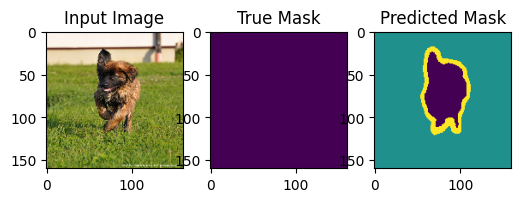

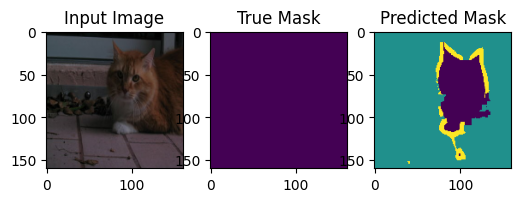

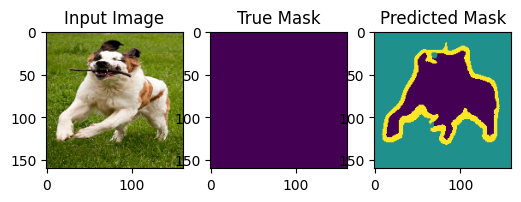

In [ ]:
for images, masks in test.take(1):
    preds = model.predict(images)

    for i in range(3):
        plt.figure(figsize=(6,6))
        plt.subplot(1,3,1)
        plt.imshow(images[i])
        plt.title("Input Image")

        plt.subplot(1,3,2)
        plt.imshow(tf.argmax(masks[i], axis=-1))
        plt.title("True Mask")

        plt.subplot(1,3,3)
        plt.imshow(tf.argmax(preds[i], axis=-1))
        plt.title("Predicted Mask")
        plt.show()


DIFFERENT DATA SET